## [How to add human-in-the-loop processes to the prebuilt ReAct agent](https://langchain-ai.github.io/langgraph/how-tos/create-react-agent-hitl/)

In [4]:
!pip install -qU langchain langsmith langchain-core langchain-community langchain-experimental langchain-openai langchain-groq pypdf langchain-text-splitters langchain-chroma faiss-cpu sentence_transformers google-search-results wikipedia duckduckgo-search arxiv langgraph yfinance

# Load Envs

In [5]:
import os
from google.colab import userdata
# os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
# os.environ['HUGGINGFACEHUB_API_TOKEN'] = userdata.get('HUGGINGFACEHUB_API_TOKEN')
os.environ['LANGSMITH_API_KEY'] = userdata.get('LANGSMITH_API_KEY')
# os.environ['SERPAPI_API_KEY'] = userdata.get('SERPAPI_API_KEY')

# Setup Langsmith

In [6]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGSMITH_API_KEY')
os.environ["LANGCHAIN_PROJECT"] = "langgraph_learning"

# LLM

In [10]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI()

# Understand Working of Tool Mapping

With tool mapping we can basically het information about the tool selected.

In [49]:
from langchain_community.tools import DuckDuckGoSearchRun
search = DuckDuckGoSearchRun()


from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())

In [51]:
# tool_kit = [search, wikipedia] # we can directly create a tool kit from here, if we want to add description, we can use the below method.

In [52]:
from langchain_core.tools import tool

@tool
def search_tool(user_input: str) -> str:
  """
  Search the web to provide answer to real time user query.

  Args:
    user_input: str

  Returns:
    Answer to the user query : str
  """
  return search.invoke(user_input)

@tool
def wikipedia_tool(user_input: str) -> str:
  """
  Use wikipedia to provide answer to historic user query.

  Args:
    user_input: str

  Returns:
    Answer to the user query : str
  """
  return wikipedia.invoke(user_input)

In [53]:
# toolkit
tools = [search_tool, wikipedia_tool]

Bind the tools

In [54]:
llm_with_tools = llm.bind_tools(tools)

## Map tools

Simple dictionary which has tool name as the key and tool as the value.

```
tool_mapping = {tool.name: tool for tool in tools}


{
  tool name : tool
}
```

In [55]:
tool_mapping = {}

for tool in tools:
  tool_mapping[tool.name] = tool

In [56]:
tool_mapping

{'search_tool': StructuredTool(name='search_tool', description='Search the web to provide answer to real time user query.\n\nArgs:\n  user_input: str\n\nReturns:\n  Answer to the user query : str', args_schema=<class 'langchain_core.utils.pydantic.search_tool'>, func=<function search_tool at 0x7e16fa9c23b0>),
 'wikipedia_tool': StructuredTool(name='wikipedia_tool', description='Use wikipedia to provide answer to historic user query. \n\nArgs:\n  user_input: str\n\nReturns:\n  Answer to the user query : str', args_schema=<class 'langchain_core.utils.pydantic.wikipedia_tool'>, func=<function wikipedia_tool at 0x7e16fa80cf70>)}

In [57]:
response = llm_with_tools.invoke("What is the capital of India?")

In [58]:
response # we saw previously that if a tool is called the content section will be empty

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_eRnDtnE3PvrydnBc5z5X9zD1', 'function': {'arguments': '{"user_input":"capital of India"}', 'name': 'search_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 130, 'total_tokens': 148, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-0b69999e-53f2-49c7-9bb8-8fc86b9b7df1-0', tool_calls=[{'name': 'search_tool', 'args': {'user_input': 'capital of India'}, 'id': 'call_eRnDtnE3PvrydnBc5z5X9zD1', 'type': 'tool_call'}], usage_metadata={'input_tokens': 130, 'output_tokens': 18, 'total_tokens': 148, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audi

### Extract Tool Details

In [59]:
response.additional_kwargs

{'tool_calls': [{'id': 'call_eRnDtnE3PvrydnBc5z5X9zD1',
   'function': {'arguments': '{"user_input":"capital of India"}',
    'name': 'search_tool'},
   'type': 'function'}],
 'refusal': None}

In [60]:
# use any - since it is a dictionary

# response.additional_kwargs['tool_calls']
response.additional_kwargs.get('tool_calls', [])

# Here we get all the details about the tool that has been used

[{'id': 'call_eRnDtnE3PvrydnBc5z5X9zD1',
  'function': {'arguments': '{"user_input":"capital of India"}',
   'name': 'search_tool'},
  'type': 'function'}]

## Now using this information, we can again call our LLM with the tool information and generate content

In [61]:
tool_details =response.additional_kwargs.get('tool_calls', [])

### Extract Question

In [62]:
query = tool_details[0]["function"]["arguments"]
query

'{"user_input":"capital of India"}'

In [63]:
# Now there is a problem here
type(query) # this is a string of dictionary -> we need to convert this to dictionary

str

In [64]:
import json
query = json.loads(query) # this will help us do it
query

{'user_input': 'capital of India'}

In [65]:
type(query)

dict

### Get the tool used

In [66]:
tool_name = tool_details[0]['function']["name"]
tool_name

'search_tool'

In [67]:
tool_used = tool_mapping[tool_name]
tool_used

StructuredTool(name='search_tool', description='Search the web to provide answer to real time user query.\n\nArgs:\n  user_input: str\n\nReturns:\n  Answer to the user query : str', args_schema=<class 'langchain_core.utils.pydantic.search_tool'>, func=<function search_tool at 0x7e16fa9c23b0>)

### Call llm

In [73]:
response = tool_used.invoke(query['user_input'])

In [74]:
response

"New Delhi, national capital of India. It is situated in the north-central part of the country on the west bank of the Yamuna River, adjacent to and just south of Delhi city (Old Delhi) and within the Delhi national capital territory. Learn more about New Delhi in this article. Delhi is a city and national capital territory in north-central India. The city of Delhi actually consists of two components: Old Delhi, in the north, the historic city; and New Delhi, in the south, since 1947 the capital of India, built in the first part of the 20th century as the capital of British India. India, country that occupies the greater part of South Asia.It is made up of 28 states and eight union territories, and its national capital is New Delhi, built in the 20th century just south of the historic hub of Old Delhi to serve as India's administrative center.Its government is a constitutional republic that represents a highly diverse population consisting of thousands of ethnic ... States and Capitals

# Building Bot

In [218]:
from langgraph.graph import MessagesState
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [219]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage
import operator

# Parent Class
class State(MessagesState):
  messages: Annotated[Sequence[BaseMessage], operator.add]

## Tools

In [220]:
from langchain_community.tools import DuckDuckGoSearchRun
search = DuckDuckGoSearchRun()


from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())

In [221]:
from langchain_core.tools import tool

@tool
def search_tool(user_input: str) -> str:
  """
  Search the web to provide answer to real time user query.

  Args:
    user_input: str

  Returns:
    Answer to the user query : str
  """
  return search.invoke(user_input)

@tool
def wikipedia_tool(user_input: str) -> str:
  """
  Use wikipedia to provide answer to historic user query.

  Args:
    user_input: str

  Returns:
    Answer to the user query : str
  """
  return wikipedia.invoke(user_input)

In [222]:
tools = [search_tool, wikipedia_tool]

### Tool Mapping

In [223]:
tool_mapping = {tool.name: tool for tool in tools}

### Bind Tool

In [224]:
llm_with_tools = llm.bind_tools(tools)

## Agent

In [225]:
def agentic_func(state: State):
  print("========== Agent ================")
  print(state)
  query = state['messages'][-1]
  print(query)
  print(type(query))
  response = llm_with_tools.invoke(query)
  return {"messages" : [response]}

In [226]:
def invoke_tools(state: State):
  print("========== Tools ================")
  print(state)
  tool_details = state['messages'][-1].additional_kwargs.get('tool_calls', [])[0]
  print(tool_details)

  if tool_details is None:
    raise Exception("No tool called")

  if tool_details['function']["name"] == "wikipedia_tool":
    # Human Intervention
    response = input(prompt=f"[y/n]?")
    if response == "n":
      return {"messages" : state['messages'][-1]}
  else:
    pass


  query = json.loads(tool_details["function"]["arguments"])
  tool_used = tool_mapping[tool_details['function']["name"]]
  response = tool_used.invoke(query['user_input'])

  print(response)

  return {"messages" : [response]}


# Router

In [227]:
def router(state: State):
  print("========== Router ================")
  print(state)
  tool_identified = state["messages"][-1]
  print(tool_identified.tool_calls)

  if tool_identified.tool_calls:
    return "Call Tool"
  else:
    return "END Node"

# Build Graph

In [228]:
from langgraph.graph import START, END, StateGraph

In [229]:
# 1. Create Instance of the Graph
workflow = StateGraph(State)


# 2. Create Nodes
workflow.add_node("Agent", agentic_func)
workflow.add_node("Tools", invoke_tools)


# 3. Create Conditional Edges
workflow.add_conditional_edges(
    "Agent",   # Tool Calling
    router, # The routing function
    {
        "Call Tool" : "Tools",
        "END Node" : END
    }
)

## Create Entry Point
workflow.add_edge(START, "Agent")

### Create End Point
workflow.add_edge("Tools", END)


# 4. Compile the Graph
my_graph = workflow.compile(checkpointer=memory)

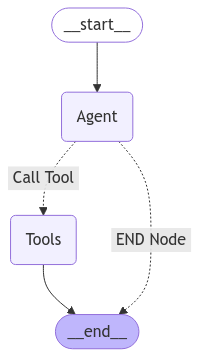

In [230]:
# 5. Display the graph
from IPython.display import Image, display

try:
    display(Image(my_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)

# Run Graph

In [231]:
config = {"configurable": {"thread_id": "1"}}

In [232]:
query = "What is the current temperature in Michigan?"
user_input = {"messages": [query]}

In [233]:
response = my_graph.invoke(user_input, config, stream_mode="values")

========== Agent ================
{'messages': ['What is the current temperature in Michigan?']}
What is the current temperature in Michigan?
<class 'str'>
========== Router ================
{'messages': ['What is the current temperature in Michigan?', AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_EVVdmMe0HmBDbzU2HRs77F5r', 'function': {'arguments': '{"user_input":"current temperature in Michigan"}', 'name': 'search_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 131, 'total_tokens': 150, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5d2998b7-d598-4e06-abaa-a33822526e16-0', tool_calls=[{'name': 'search_tool', '

In [234]:
response['messages'][-1]

'Currently, in Michigan, clouds cover most of the sky. The temperature is a subzero 15.8°F (-9°C), while the felt air temperature, due to the wind, is estimated at a frigid 8.6°F (-13°C).The current temperature is almost at the minimum-expected 14°F (-10°C) for today. In Detroit, at the moment, the clouds are noticeable in the skyline. The temperature is a freezing 23°F (-5°C), while the apparent temperature, due to the wind, is appraised at an extreme-cold 10.4°F (-12°C).The current temperature is nearly at the maximum anticipated 24.8°F (-4°C) for today. Current conditions at Coleman A Young Municipal Airport (KDET) Lat: 42.41°NLon: 83.01°WElev: 620ft. Fair. 18°F-8°C. Humidity: 68%: Wind Speed: W 8 mph: Barometer: ... Hourly Weather Forecast. National Digital Forecast Database. High Temperature. Chance of Precipitation. ACTIVE ALERTS Toggle menu. Warnings By State; Excessive Rainfall; Hazardous Weather Conditions. Hazardous Weather Outlook ; Current conditions at Coleman A Young Muni

In [235]:
query = "Who is Kobe Bryant?"
user_input = {"messages": [query]}

In [236]:
response = my_graph.invoke(user_input, config, stream_mode="values")

========== Agent ================
{'messages': ['What is the current temperature in Michigan?', AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_EVVdmMe0HmBDbzU2HRs77F5r', 'function': {'arguments': '{"user_input":"current temperature in Michigan"}', 'name': 'search_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 131, 'total_tokens': 150, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5d2998b7-d598-4e06-abaa-a33822526e16-0', tool_calls=[{'name': 'search_tool', 'args': {'user_input': 'current temperature in Michigan'}, 'id': 'call_EVVdmMe0HmBDbzU2HRs77F5r', 'type': 'tool_call'}], usage_metadata={'input_tokens': 131, 

In [237]:
response['messages'][-1]

"Page: Kobe Bryant\nSummary: Kobe Bean Bryant ( KOH-bee; August 23, 1978 – January 26, 2020) was an American professional basketball player. A shooting guard, he spent his entire 20-year career with the Los Angeles Lakers in the National Basketball Association (NBA). Widely regarded as one of the sport's greatest and most influential players of all time, Bryant won five NBA championships and was an 18-time All-Star, 15-time member of the All-NBA Team, 12-time member of the All-Defensive Team, the 2008 NBA Most Valuable Player (MVP), and a two-time NBA Finals MVP. He ranks fourth in league all-time regular season and postseason scoring. Bryant was posthumously voted into the Naismith Memorial Basketball Hall of Fame in 2020 and named to the NBA 75th Anniversary Team in 2021.\nThe son of NBA player Joe Bryant, Bryant was born in Philadelphia and partly raised in Italy. Recognized as the top American high-school basketball player while at Philadelphia suburb Lower Merion, Bryant declared 